In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
pth_data = os.path.join('..', 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_ref = os.path.join(pth_data, 'figures')
pth_out = os.path.join('..', 'figures', 'cancer')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'CCCA_malignant.h5ad'))
adata

AnnData object with n_obs × n_vars = 1434229 × 856
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'ebv', 'celltype', 'Title', 'Category', 'Disease', 'Technology', 'Samples', 'Cells ', 'Name', 'patient', 'cell_subtype', 'source', 'disease', 'p16_status', 'site', 't_stage', 'n_stage', 'gender', 'race', 'age', 'tobacco_use', 'alcohol_use', 'hpv', 'hpv_score', 'treatment', 'procedure', 'sorting', 'cluster', 'malignant', 'sample_id', 'cell_subtype_clusters', 'tnm_stage', 'treatment_exposure', 'treatment_response', 'cell_lineage', 'type', 'clusters_by_authors', 'cell_QCpass', 'is_tumor', 'cell_compartment', 'cluster_assignment', 'metastasis', 'sex', 'prior_enzalutamide', 'prior_abiraterone', 'prior_taxane', 'prior_platinum', 'prior_sipuleucel_T', 'purity', 'has_bulk_RNA', 'cancer_cell_state', 'PSA', 'source_region', 'gleason_score', 'ERG_status', 'cores', 'post_op_gleason_score', 'margin

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
# attributions — 3CA (diseases)
src_train = df.loc[df.Training == True].index
grp = adata.obs.groupby('Disease', observed = True)
z = grp.latent_z.mean().sort_values(ascending = False)
attr_cancer = grp[src_train].mean().loc[z.index]

# PCA — training celltypes
fn = os.path.join(pth_ref, 'attributions.csv')
attr = pd.read_csv(fn, index_col = [0, 1])
pca = PCA(n_components = 2).fit(attr)
attr_pca = pd.DataFrame(pca.transform(attr),
                        index = attr.index,
                        columns = ['PC1', 'PC2'])

# project diseases
attr_cancer_pca = pd.DataFrame(pca.transform(attr_cancer),
                               index = attr_cancer.index,
                               columns = ['PC1', 'PC2'])

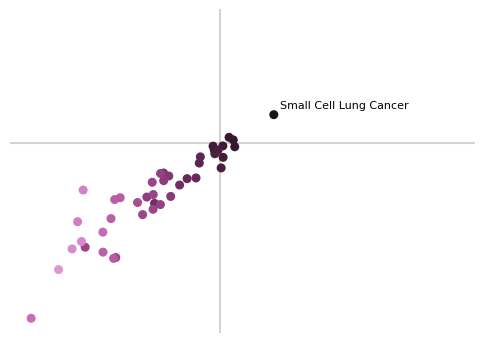

In [13]:
# plot diseases
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.scatter(attr_pca.PC1, attr_pca.PC2, alpha = 0)
ax.scatter(attr_cancer_pca.PC1, attr_cancer_pca.PC2,
  c = z, vmin = 0, vmax = 1, cmap = 'vanimo', s = 30)

# label
xy = attr_cancer_pca.iloc[0] + .0075
s = attr_cancer_pca.index[0]
ax.text(*xy, s, size = 8, ha = 'left')

ax.axhline(0, c = 'lightgray', zorder = 0)
ax.axvline(0, c = 'lightgray', zorder = 0)
ax.set_aspect(1); ax.axis(False)

fn = os.path.join(pth_out, 'interpret.pdf')
plt.savefig(fn, bbox_inches = 'tight')